# Solutions Assignment 2
Author: Luis Denninger

In [3]:
import os
from pathlib import Path as P

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

import torchvision as tv

import matplotlib.pyplot as plt

import yaml

import copy

from tqdm import tqdm

import optuna

import plotly

## Models

### Multi-layer Perceptron


In [13]:
class MLP_Classifier(nn.Module):

    def __init__(self,
                    input_dim: int,
                    mlp_layers: list,
                    ):
        """
        Initialization of a multi-layer perceptron.

        Parameters:
            input_dim (int): Size of the input.
            mlp_layers (list): List containing the sizes and types of the mlp layers. Number of elements determines the number of layers.
                Format: 
                    [
                        {
                            'type': 'linear',
                            'dimension': 128
                        },
                        {
                            'type': 'relu',
                            'dimension': 128,
                        }
                        {
                            'type': 'batchnorm',
                            'eps':1e-5,
                            'momentum': 0.1
                        },
                        {
                            'type': 'dropout',
                            'prob': 0.5
                        }
                    ]
            output_dim (int): Size of the output.
        """
        
        super(MLP_Classifier, self).__init__()
        self.build_up_model(input_dim, mlp_layers)

    def build_up_model(self, input_dim: int, mlp_layers: list):
        # Build the model and each layer according to the config
        layers = nn.ModuleList()
        for (i, layer) in enumerate(mlp_layers):
            layer_inp_dim = input_dim if i == 0 else mlp_layers[i-1]['dimension']
            # Add a linear layer with a given activation function
            if layer['type'] == 'linear':
                layers.append(nn.Linear(layer_inp_dim, layer['dimension']))
            elif layer['type'] =='relu':
                layers.append(nn.ReLU())
            elif layer['type'] == 'tanh':
                layers.append(nn.Tanh())
            elif layer['type'] =='sigmoid':
                layers.append(nn.Sigmoid())
            elif layer['type'] == 'elu':
                layers.append(nn.ELU())
            elif layer['type'] =='selu':
                layers.append(nn.SELU())
            elif layer['type'] == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif layer['type'] == 'prelu':
                layers.append(nn.PReLU())
            elif layer['type'] == 'softmax':
                layers.append(nn.Softmax(dim=-1))
            elif layer['type'] =='batchnorm':
                layers.append(nn.BatchNorm1d(layer_inp_dim, layer['eps'], layer['momentum']))
            elif layer['type'] == 'dropout':
                layers.append(nn.Dropout(layer['prob']))
            
        self.model = nn.Sequential(*layers)
            

    
    def forward(self, x):
        return self.model(x)
    

def build_model(config: dict):
    # Build the model from the given config
    # Since the above model was taken from a broader framework that has more flexibility, we have to convert our simpler config file
    layer_config = []
    for layer in config['layers']:
        # Add each layer
        if type(layer) == int:
            layer_config.append({
                'type': 'linear',
                'activation': config['activation'],
                'dimension': layer})
        else:
            if layer == 'batchnorm':
                layer_config.append({
                    'type': 'batchnorm',
                    'dimension': layer_config[-1]['dimension'],
                    'eps': 1.0e-05,
                    'momentum': 0.1})
            if layer == 'dropout':
            # Add dropout layers in between if wanted
                layer_config.append({
                    'type': 'dropout',
                    'dimension': layer_config[-1]['dimension'],
                    'prob': 0.5})
    # Append final output layer
    layer_config.append({'type': 'linear',
            'activation': 'softmax',
            'dimension': config['output_dim']})
    
    model = MLP_Classifier(config['input_dim'], layer_config)

    return model

### Convolutional Neural Network

In [ ]:


class ConvolutionalNN(nn.Module):
    
    def __init__(self, 
                    layers: list,):
        """
            Convolutional Neural Network. The layers are fully configurable by providing a simple config for each layer

            Parameters:
                layers (list): list of layers to be configured
                    Format:
                            [
                                {
                                    "type": "Conv2d",
                                    "in_channels": 1,
                                    "out_channels": 1,
                                    "kernel_size": 3,
                                }, 
                                {
                                    "type": "ReLu"
                                },
                                {
                                    "type": "MaxPool2d",
                                    "kernel_size": 2
                                }
                                {
                                    "type": "Linear",
                                    "in_features": 512,
                                    "out_features": 10
                                }
        """

        super(ConvolutionalNN, self).__init__()

        self.build_model


    def build_model(self, layers):
        layers = nn.ModuleList()
        for (i, layer) in enumerate(layers):
            if layer["type"] == "Conv2d":
                layers.append(nn.Conv2d(layer["in_channels"], layer["out_channels"], layer["kernel_size"]))
            elif layer["type"] == "ReLu":
                layers.append(nn.ReLU())
            elif layer["type"] == "MaxPool2d":
                layers.append(nn.MaxPool2d(layer["kernel_size"]))

            # Add a linear layer with a given activation function
            if layer['type'] == 'linear':
                layers.append(nn.Linear(in_features=layer['in_features'], out_features=layer['out_features']))
            if layer['type'] =='batchnorm':
                layers.append(nn.BatchNorm1d(layer['in_features'], layer['eps'], layer['momentum']))
            if layer['type'] == 'dropout':
                layers.append(nn.Dropout(layer['prob']))
            
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.model(x)
        return x
        

## Data

In [4]:
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=False, transform=transforms.ToTensor(), download=True)


def load_data(config):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers = 8)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True, num_workers = 8)
    return train_loader, test_loader

print('\n')

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Train dataset size: 60000
Test dataset size: 10000


torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])
torch.Size([28, 28, 1])


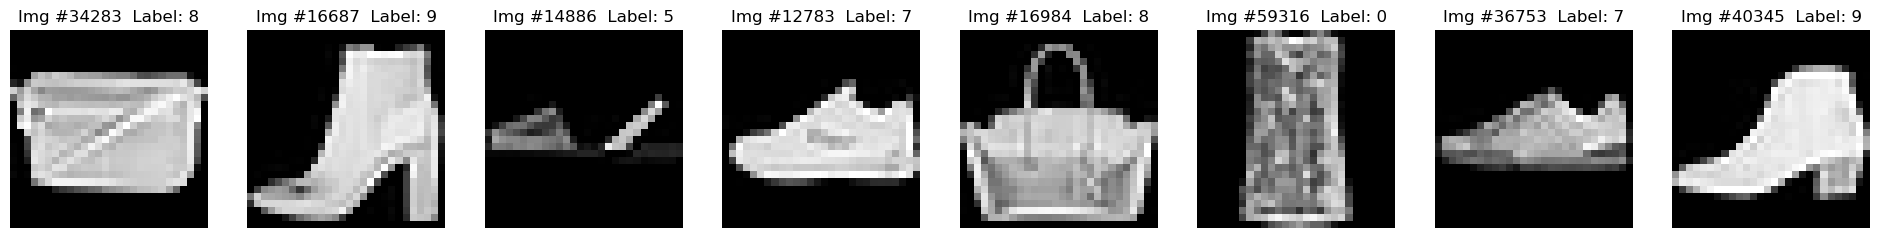

In [8]:
###--- Visualize Training Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = train_dataset[n][0].permute(1,2,0)
    label = train_dataset[n][1]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")


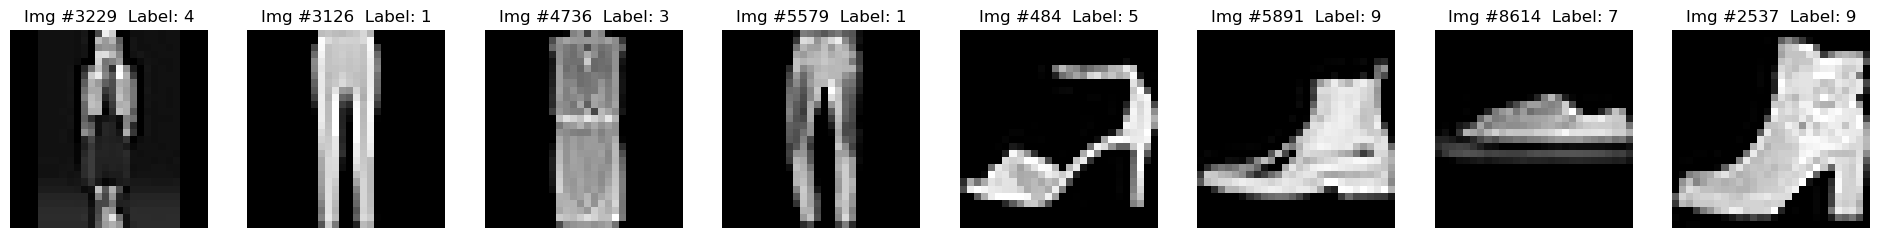

In [7]:
###--- Visualize Evaluation Images ---###

NUM_IMG = 8

fig, ax = plt.subplots(1,NUM_IMG)
fig.set_size_inches(3 * NUM_IMG, 3)

ids = np.random.randint(low=0, high=len(test_dataset), size=NUM_IMG)

for i, n in enumerate(ids):
    img = test_dataset[n][0].permute(1,2,0)
    label = test_dataset[n][1]
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {label}")
    ax[i].axis("off")

## Scripts/Functions

### Data Augmentation and Preprocessing

In [9]:

class DataAugmentor:
    """
        Module to apply pre-defined data augmentations.
    
    """

    def __init__(self, config):
        self.config = config

        self.flatten_img = config['flatten_img']
        self.flatten_only_img_size = config['flatten_only_img_size']
        self.rgb2gray = config['rgb2gray']
        self.normalize = config['normalize']
    
    def __call__(self, image, train=True):
        if self.rgb2gray:
            image = self._rgb2grayscale(image)
        if self.flatten_img:
            image = self._flatten_img(image)
        if self.normalize:
            image = self._normalize(image)
    ## Processing Functions ##    

    def _flatten_img(self, input: torch.Tensor):
        # Flatten only the image size dimensions
        if self.flatten_only_img_size:
            return torch.flatten(input, start_dim=-2)
    
        # Flatten all dimensions except of the batch dimension
        else:
            return torch.flatten(input, start_dim=1)

    def _rgb2grayscale(self, input: torch.Tensor):
        return tv.transforms.Grayscale()(input)
    
    def _normalize_img(self, input: torch.Tensor):
        return tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(input)

### Evaluation

In [10]:
###--- Evaluation Scripts ---###

def run_evaluation( model: torch.nn.Module, 
                    data_augmentor: DataAugmentor,
                    dataset: torch.utils.data.DataLoader, 
                    config: dict,
                    criterion = None,
                    suppress_output: bool = False):
    """
        Runs evaluation of the given model on the given dataset.

        Arguments:
            model (torch.nn.Module): The model to evaluate.
            dataloader (torch.utils.data.DataLoader): The dataloader to evaluate on.
            config (dict): The configuration dictionary.
            device (str, optional): The device to evaluate on. Defaults to "cpu".

    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Setup model for evaluation
    model.eval()
    model.to(device)

    eval_metrics = {}

    with torch.no_grad():
        if suppress_output:
            progress_bar = enumerate(dataset)
        else:
            progress_bar = tqdm(enumerate(dataset), total=len(dataset))
            progress_bar.set_description(f'Evaluation:')
        outputs = []
        targets = []
        losses = []
        for i, (imgs, labels) in progress_bar:
            
            labels_raw = torch.clone(labels)
            imgs, labels = imgs.to(device), labels.to(device)

            # apply preprocessing surch as flattening the imgs and create a one hot encodinh of the labels
            imgs = data_augmentor(imgs, train=False)

            imgs, labels = imgs.float(), labels.float()

            output = model(imgs).float()

            outputs.append(output.cpu())
            targets.append(labels_raw.cpu())
            if criterion is not None:
                loss = criterion(output, labels)
                losses.append(loss.item())
        
        for eval_metric in config['evaluation']['metrics']:
            func_name = '_evaluation_' + eval_metric
            try:
                eval_metrics[eval_metric] = globals()[func_name](torch.stack(outputs, dim=0), torch.stack(targets, dim=0), config)
            except:
                print(f"NotImplemented: Evaluation metric {eval_metric}")

    if criterion is None:
        return eval_metrics
    
    return eval_metrics, sum(losses) / len(losses)

    
## Evaluation Metrics ##

def _evaluation_accuracy(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the accuracy of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The accuracy of the given model on the given dataset.
    """

    _, predicted = torch.max(output, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    total = target.shape[0]
    correct = (predicted == target).sum().item()

    return [correct / total]

def _evaluation_precision(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return [sum(class_precision) / len(class_precision)]

def _evaluation_precision_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the precision of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The precision of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, -1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_precision = []

    for label in CLASSES:
        tp = ( (predicted == label) and (target == label) ).sum().item()
        fp = ( (predicted == label) and (target!= label) ).sum().item()
        class_precision.append(tp / (tp + fp))

    return class_precision


def _evaluation_recall(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted != label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return sum(class_recall) / len(class_recall)

def _evaluation_recall_per_class(output: torch.Tensor, target: torch.Tensor, config: dict) -> list:
    """
        Computes the recall of the the predictions given the target for each class separately.

        Arguments:
            output (torch.Tensor): The output of the model.
            target (torch.Tensor): The target of the model.

        Returns:
            float: The recall of the given model on the given dataset.
    """
    assert 'classes' in config['evaluation']
    
    # Discrete set of classes for the classification task
    CLASSES = config['evaluation']['classes']
    _, predicted = torch.max(output.data, 1)

    if len(predicted.shape)==2 and len(target.shape)==2:
        predicted = torch.flatten(predicted)
        target = torch.flatten(target)

    class_recall = []

    for label in CLASSES:
        tp = ((predicted == label) and (target == label) ).sum().item()
        fn = ( (predicted!= label) and (target == label) ).sum().item()
        class_recall.append(tp / (tp + fn))

    return class_recall

### Training

In [15]:
from experiments import Logger


def train_model(model, config, train_loader, val_loader, optimizer, criterion,  data_augmentor: DataAugmentor, scheduler=None, logger: Logger=None):

    ###--- Hyperparameters ---###

    EPOCHS = config['num_epochs']
    ITERATIONS = config['num_iterations']

    evaluation_config = config['evaluation']

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ###--- Training ---###
    
    # Train for EPOCHES epochs and evaluate the model according to the pre-defined frequency
    for epoch in range(EPOCHS):
        print('\n Epoch {}/{}'.format(epoch + 1, EPOCHS))
        
        model.train()

        ###--- Training Epoch ---###
        progress_bar = tqdm(enumerate(train_loader), total=config['num_iterations'])
        for i, (img, label) in progress_bar:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            # Apply data augmentation and pre-processing
            img = data_augmentor(img)
            # Zero gradients
            optimizer.zero_grad()
            # Compute output of the model
            output = model(img)
            # Compute loss
            loss = criterion(output, label)
            # Backward pass to compute the gradients wrt to the loss
            loss.backward()
            # Update weights
            optimizer.step()
            # Log training data
            if logger is not None:
                logger.log_metrics(data={'train_loss': loss.cpu().item()}, epoch=epoch+1, iteration=i+1)

        if scheduler is not None:
            # Learning rate scheduler takes a step
            scheduler.step()
        
        ###--- Evaluation Epoch ---###
        if epoch % evaluation_config['frequency'] == 0:
            evaluation_metrics, eval_loss = run_evaluation(model,data_augmentor,val_loader,config, criterion, suppress_output=False)

        # Log evaluation data
        if logger is not None:
            logger.log_metrics(epoch=epoch+1, data=evaluation_metrics)
            logger.log_metrics(epoch=epoch+1, data={'eval_loss': eval_loss.cpu().item()})
        
        # If the logger is activated and saves the data internally we can print out the data after each epoch
        if logger is not None and logger.save_internal:
            logs = logger.get_last_log()
            print("".join([(f' {key}: {value},') for key, value in logs.items()]))
        

    
    
        


## Comparison MLP and CNN

### MLP Model

In [14]:
MLP_MODEL_CONFIG =  {
                            'input_dim': 3072,
                            'layers': [
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},
                                {'type': 'linear', 'dimension': 512},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},

                                {'type': 'linear', 'dimension': 256},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 128},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},

                                {'type': 'linear', 'dimension': 64},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 10},
                                {'type': 'softmax'},

                            ],
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 20,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': {
                                'flatten': True,
                                'flatten_only_img_size': False,
                                'rgb2gray': False,
                                'lbl_oneHot': False,
                                'squeeze': True
                            },
                            'evaluation': {
                                'metrics': ['accuracy'],
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            }
                            
                        }

In [ ]:

###-- Initialization ---###
mlp_model = MLP_Classifier(MLP_MODEL_CONFIG['input_dim'], MLP_MODEL_CONFIG['layers'])

mlp_train_loader, mlp_test_loader = load_data(MLP_MODEL_CONFIG)

criterion = torch.nn.CrossEntropyLoss()

mlp_optimizer = torch.optim.Adam(lr=MLP_MODEL_CONFIG['learning_rate'])

mlp_logger = Logger(model_config=MLP_MODEL_CONFIG, save_external=False, save_internal=True)

mlp_data_augmentor = DataAugmentor(config=MLP_MODEL_CONFIG['pre_processing'])

train_model(model=mlp_model, config=MLP_MODEL_CONFIG, train_loader=mlp_train_loader, val_loader=mlp_test_loader, optimizer=mlp_optimizer, criterion=criterion, logger=mlp_logger)

### CNN Model

CNN_MODEL_CONFIG =  {
                            'input_dim': 3072,
                            'layers': [
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},
                                {'type': 'linear', 'dimension': 512},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},

                                {'type': 'linear', 'dimension': 256},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 128},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},

                                {'type': 'linear', 'dimension': 64},
                                {'type': 'batchnorm'},
                                {'type': 'leaky_relu'},
                                {'type': 'dropout', 'dimension': 786, 'prob': 0.1},

                                {'type': 'linear', 'dimension': 10},
                                {'type': 'softmax'},

                            ],
                            'output_dim': 10,
                            'dropout': False,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 20,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': {
                                'flatten': True,
                                'flatten_only_img_size': False,
                                'rgb2gray': False,
                                'lbl_oneHot': False,
                                'squeeze': True
                            },
                            'evaluation': {
                                'metrics': ['accuracy'],
                            },
                            'dataset': {
                                    'name': 'fashionMNIST',
                                    'train_size': 60000,
                                    'val_size': 0,
                                    'test_size': 10000,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                            }
                            
                        }